# Capstone project -- Opening a restaurant

## Introduction and business problem

### Problem Description

Nowadays, it is difficult to imagine a city without a restaurant or a venue for food where people can have a meal or drink. The city of my choose is Taganrog that is the leading historic, cultural and industrial center in the South of Russia. Local industry and businesses are represented by aerospace, machine-building, military, iron and steel industry, farming, food, theathers, museums and one of the major ports of Azov Sea. That means there are a lot of business opportunities for restaurant business what leads to high competition.

To survive in such competitive market it is very important to find right place and take into account many other important factors such as:
* City population
* Sport and Entertainment zones
* Food markets with products of local farmers
* Local competitors and their ratings
* etc

In order to reduce the risks and avoid loss of money, the analysis of all accessible data should be carried out carefully in order to choose a suitable place or location. In my opinion, even an amazing idea or ingenious concept will not make your restaurant business successful without suitable place for it.

Obviously, this project will be interesting for a big company as well as anyone who wants to open a new restaurant in Taganrog city.


## Data description

The city of <b>Taganrog</b> (located in the South of Russia) will be analyzed in this project.

To solve the problem of finding the right location, we should find all existing businesses in the city of interest, explore them carefully to understand what we already have and plot our venues on map to gain insights, possible patterns or clusters.

For further analysis we will use the following data sources:
1. Wikipedia page for city population (https://en.wikipedia.org/wiki/Taganrog)
2. Nominatim search engine for OpenStreetMap data to get the bounding box of the city
    (https://nominatim.openstreetmap.org/search?format=json&q=Taganrog&polygon_geojson=1)
3. Foursquare API

Foursquare will be used as the main data source for analysis. We will retrieve both geographical coordinates and additional information about each venue using Foursquare API.

The following attributes for each venue will be collected:
* Id -- venue id (in order to remove duplicates)
* Venue -- venue name
* Category -- venue category
* Location -- venue address
* Latitude -- venue latitude
* Longitude -- venue longitude
* Rating -- numerical rating of the venue (0 through 10)
* Tips -- total count of tips
* Likes -- the count of users who have liked this venue

Because of Taganrog city has no neighborhood division like cities in the United States, we will build a coordinate grid that will cover the entire city by cells (or squares) of size 0.005x0.005 or 700x700 metre approximately.
South-west (sw) and north-east (ne) corners of cells will be utilized as input for the <b>search</b> endpoint of Foursquare API.

#### Example of coordinate grid

In [33]:
url_bounds = 'https://nominatim.openstreetmap.org/search?format=json&q=Taganrog, Russia&polygon_geojson=1'
# get borders in json format
result = requests.get(url_bounds).json()[0]
bounds = result['boundingbox']
# convert to float
city_rect = [float(i) for i in bounds] 
city_center = [float(result['lat']), float(result['lon'])]
print('city rect:', city_rect)
print('city center:', city_center)

city rect: [47.1887122, 47.2899427, 38.7929772, 38.9701473]
city center: [47.2153657, 38.9285216]


In [34]:
grid_step = 0.005
map_tag = folium.Map(location=city_center, zoom_start=12)
map_tag.fit_bounds([[city_rect[0], city_rect[2]], [city_rect[1], city_rect[3]]])

for lat in np.arange(city_rect[0], city_rect[1], grid_step):
    for lon in np.arange(city_rect[2], city_rect[3], grid_step):
        folium.Rectangle([[lat, lon], [lat+grid_step, lon+grid_step]], color='red', weight=0.3).add_to(map_tag)
        
map_tag

#### Example of data from Foursquare
The first five venues within 700 meters bounding box of city center are below:

In [305]:
# first five rows

,Venue,Latitude,Longitude,Category,Id
0,Площадь перед администрацией города,47.215733,38.928230,Plaza,5368f4ad498ea0cb80cef632
1,Культ вина,47.215510,38.929310,Wine Bar,5c74142e60255e002c1aefbc
2,Театр имени А. П. Чехова,47.216325,38.928217,Theater,4dcbe98a1f6ea1401d49d12a
3,Администрация Таганрога,47.215517,38.928420,City Hall,4da693d90cb66f658708dafc
4,Л'Этуаль,47.215416,38.929266,Cosmetics Shop,4f83002ee4b0b2237e8a6cb1


When data collected, the general approach to solution is to cluster venues in the city and identify what cluster fit best of all. It may either be a cluster with the most popular venues for food or a cluster having similar parameters but the least vanues for food.

## Data collection

Let's import all necessary packages

In [93]:
import numpy as np 
import pandas as pd
import json 

from geopy.geocoders import Nominatim

import requests 
from pandas.io.json import json_normalize

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium 
import time

import matplotlib.pyplot as plt

# Methodology

This section focuses on data understanding and data preparation of previously collected data, exploratory analysis, and clustering. 

* Understanding and preparation: the data needs to be cleaned and prepared: fields renamed, NaN's fixed;

* Exploratory analysis includes check field distributions, detect any outliers, exploring correlation between fields and discarding erroneous or not needed data;
    
* Clustering -- the core Machine Learning methodology and a very popular clustering algorithm, called k-means is used in this project. The major focus of the project is to determine the optimum number of clusters and finding suitable cluster for a new restaurant. 
    

### Understanding and preparation
Let's load and see the dataset of venues.

In [7]:
city_venues = pd.read_csv('city_venues.csv')
city_venues.head()

,Venue,Latitude,Longitude,Category,Id,Rating,Likes,Tips,PostalCode,Price_tier,createdAt,Category_id
0,золотое руно,47.176498,38.810475,Hotel Pool,55a0e60c498e873de699ccd1,0.0,7.0,0.0,347900.0,0.0,1.436608e+09,4bf58dd8d48988d132951735
1,Пятерочка,47.182352,38.818977,Supermarket,58401718e9233e42ab37615e,5.8,1.0,0.0,347900.0,0.0,1.480595e+09,52f2ab2ebcbc57f1066b8b46
2,Петрушанская Коса,47.174113,38.865204,Beach,51ecf0f2498edbbbb8c6c29d,0.0,0.0,0.0,347900.0,0.0,1.374483e+09,4bf58dd8d48988d1e2941735
3,село Боцманово,47.173903,38.755930,Vineyard,53f917c4498e47b1dc40249e,0.0,1.0,0.0,347900.0,0.0,1.408833e+09,4bf58dd8d48988d1de941735
4,"Остановка ""Новозолотовка""",47.179577,38.795387,Bus Line,516166d9e4b0d19a95e6b214,0.0,0.0,0.0,347900.0,0.0,1.365338e+09,4bf58dd8d48988d12b951735


In [25]:
# Remove any neighborhood that may have NaN's
city_venues.dropna(inplace = True, axis = 0)
print(city_venues.shape)

(3525, 12)


In [26]:
# examine column's types
city_venues.dtypes

Venue           object
Latitude       float64
Longitude      float64
Category        object
Id              object
Rating         float64
Likes          float64
Tips           float64
PostalCode     float64
Price_tier     float64
createdAt      float64
Category_id     object
dtype: object

#### Display collected venues on map
Here we defien two function for displaying venues on map: plot_venues and plot_venues_with_rect

In [58]:
# define a function to plot venues on map
def plot_venues(venues, loc):
    map_ = folium.Map(location=loc, zoom_start=13)
   
    # add markers to map
    for lat, lng, name, cat in zip(venues['Latitude'], venues['Longitude'], venues['Venue'], venues['Category']):
        label = '{}, {}'.format(name, cat)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_)  
    return map_

# add rectangle
def plot_venues_with_rect(venues, sw, ne):
    map_ = plot_venues(venues, sw)
    # add bounding box 
    map_.fit_bounds([sw, ne])
    folium.Rectangle([sw, ne], color='red').add_to(map_)
    return map_

In [59]:
# for some reason the max number of venues the folium can display is 1500 
plot_venues_with_rect(city_venues.iloc[1500:3000], sw=[city_rect[0], city_rect[2]], ne=[city_rect[1], city_rect[3]])

#### Remove venues out of the bounding box

### Exploratory Analysis

Let's examine the **'createdAt'** field. This field contains amount of seconds since epoch when the venue was created.
Let's convert timestamp in seconds to years and find a range of years.

In [74]:
city_venues['Created_year'] = city_venues['createdAt'].apply(lambda t: time.gmtime(t).tm_year)
city_venues.head()

,Venue,Latitude,Longitude,Category,Id,Rating,Likes,Tips,PostalCode,Price_tier,createdAt,Category_id,Created_year
0,золотое руно,47.176498,38.810475,Hotel Pool,55a0e60c498e873de699ccd1,0.0,7.0,0.0,347900.0,0.0,1.436608e+09,4bf58dd8d48988d132951735,2015
1,Пятерочка,47.182352,38.818977,Supermarket,58401718e9233e42ab37615e,5.8,1.0,0.0,347900.0,0.0,1.480595e+09,52f2ab2ebcbc57f1066b8b46,2016
2,Петрушанская Коса,47.174113,38.865204,Beach,51ecf0f2498edbbbb8c6c29d,0.0,0.0,0.0,347900.0,0.0,1.374483e+09,4bf58dd8d48988d1e2941735,2013
3,село Боцманово,47.173903,38.755930,Vineyard,53f917c4498e47b1dc40249e,0.0,1.0,0.0,347900.0,0.0,1.408833e+09,4bf58dd8d48988d1de941735,2014
4,"Остановка ""Новозолотовка""",47.179577,38.795387,Bus Line,516166d9e4b0d19a95e6b214,0.0,0.0,0.0,347900.0,0.0,1.365338e+09,4bf58dd8d48988d12b951735,2013


In [80]:
city_venues['Venue_age'] = city_venues['Created_year'].apply(lambda y: 2019 - y)
city_venues.head()

,Venue,Latitude,Longitude,Category,Id,Rating,Likes,Tips,PostalCode,Price_tier,createdAt,Category_id,Created_year,Venue_age
0,золотое руно,47.176498,38.810475,Hotel Pool,55a0e60c498e873de699ccd1,0.0,7.0,0.0,347900.0,0.0,1.436608e+09,4bf58dd8d48988d132951735,2015,4
1,Пятерочка,47.182352,38.818977,Supermarket,58401718e9233e42ab37615e,5.8,1.0,0.0,347900.0,0.0,1.480595e+09,52f2ab2ebcbc57f1066b8b46,2016,3
2,Петрушанская Коса,47.174113,38.865204,Beach,51ecf0f2498edbbbb8c6c29d,0.0,0.0,0.0,347900.0,0.0,1.374483e+09,4bf58dd8d48988d1e2941735,2013,6
3,село Боцманово,47.173903,38.755930,Vineyard,53f917c4498e47b1dc40249e,0.0,1.0,0.0,347900.0,0.0,1.408833e+09,4bf58dd8d48988d1de941735,2014,5
4,"Остановка ""Новозолотовка""",47.179577,38.795387,Bus Line,516166d9e4b0d19a95e6b214,0.0,0.0,0.0,347900.0,0.0,1.365338e+09,4bf58dd8d48988d12b951735,2013,6


We have transformed the 'createdAt' column in two new columns: 'Created_year' and 'Venue_age' and can drop it now.

In [ ]:
city_venues = city_venues.drop('createdAt', 1)

Now, let's examine the **'PostalCode'** field.

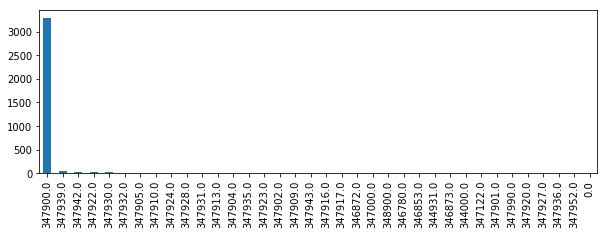

In [127]:
city_venues['PostalCode'].value_counts().plot(kind='bar', figsize=(10,3))

It is obvious that this column is useless because majority venues have postal code equal to 347900. Drop this column as well.

In [122]:
city_venues = city_venues.drop('PostalCode', 1)

347900.0    3286
347939.0      44
347942.0      32
347922.0      32
347930.0      18
347932.0      16
347905.0      10
347910.0       9
347924.0       9
347928.0       8
347931.0       7
347913.0       7
347904.0       6
347935.0       5
347923.0       5
347902.0       3
347909.0       3
347943.0       3
347916.0       2
347917.0       2
346872.0       2
347000.0       2
348900.0       1
346780.0       1
346853.0       1
344931.0       1
346873.0       1
344000.0       1
347122.0       1
347901.0       1
347990.0       1
347920.0       1
347927.0       1
347936.0       1
347952.0       1
0.0            1
Name: PostalCode, dtype: int64